In [19]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages
library(randomForest)
require(caTools)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input/trainandvalid-blubookbulldozer/TrainAndValid.csv")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

character(0)

# Load and explore data

In [88]:
data <- read_csv("../input/trainandvalid-blubookbulldozer/TrainAndValid.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  SalesID = col_double(),
  SalePrice = col_double(),
  MachineID = col_double(),
  ModelID = col_double(),
  datasource = col_double(),
  auctioneerID = col_double(),
  YearMade = col_double(),
  MachineHoursCurrentMeter = col_double()
)
ℹ Use `spec()` for the full column specifications.




## Checking missing values

In [89]:
# see how many missing values are in each variable, makw a percentage of NAs in each variable
tmp_data <- as.data.frame(apply(is.na(data), 2, sum))
colnames(tmp_data) <- c("NA_values")
tmp_data$percentage_NA <- round((tmp_data$NA_values / nrow(data))*100)
tmp_data$variables <- rownames(tmp_data)
tmp_data

,NA_values,percentage_NA,variables
,<int>,<dbl>,<chr>
SalesID,0,0,SalesID
SalePrice,0,0,SalePrice
MachineID,0,0,MachineID
ModelID,0,0,ModelID
datasource,0,0,datasource
auctioneerID,20136,5,auctioneerID
YearMade,0,0,YearMade
MachineHoursCurrentMeter,265194,64,MachineHoursCurrentMeter
UsageBand,339028,82,UsageBand


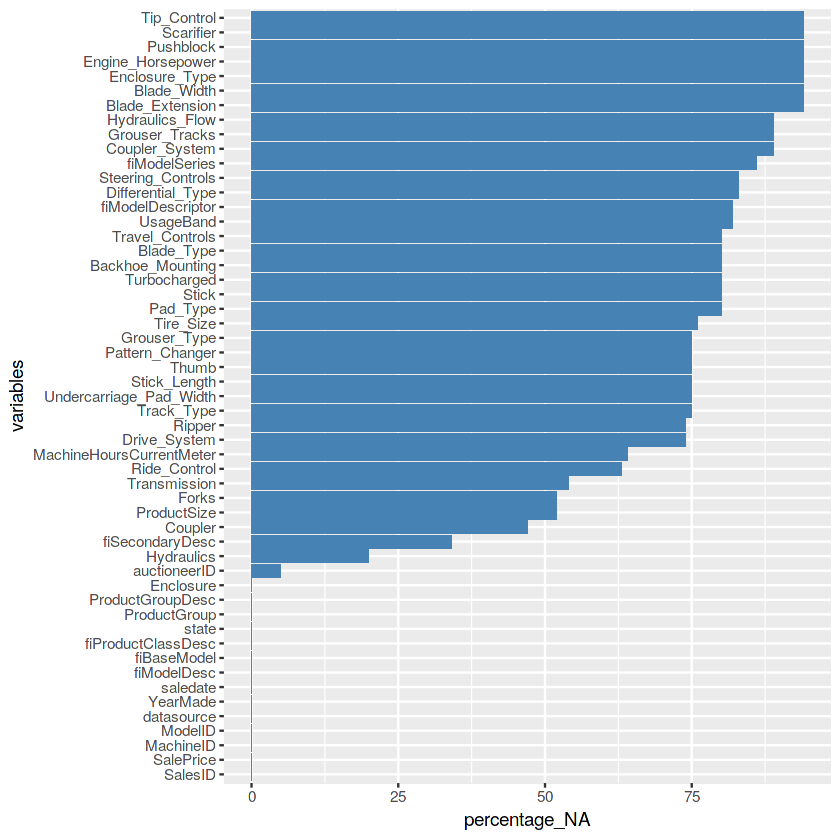

In [90]:
# sort table with NAs so that its ordered (necesssary for plotting)
tmp_data <- tmp_data[order(tmp_data$percentage_NA),]
tmp_data$variables <- factor(tmp_data$variables, levels = tmp_data$variables)

ggplot(data=tmp_data, aes(x=percentage_NA, y=variables)) +
geom_bar(stat="identity", fill="steelblue")

In [109]:
# select columns (variables) that have <= 80% of NAs
data_new <- data[,tmp_data[tmp_data$percentage_NA <= 75,]$variables]
colnames(data_new)

[1] "SalesID"                  "SalePrice"               
 [3] "MachineID"                "ModelID"                 
 [5] "datasource"               "YearMade"                
 [7] "saledate"                 "fiModelDesc"             
 [9] "fiBaseModel"              "fiProductClassDesc"      
[11] "state"                    "ProductGroup"            
[13] "ProductGroupDesc"         "Enclosure"               
[15] "auctioneerID"             "Hydraulics"              
[17] "fiSecondaryDesc"          "Coupler"                 
[19] "ProductSize"              "Forks"                   
[21] "Transmission"             "Ride_Control"            
[23] "MachineHoursCurrentMeter" "Drive_System"            
[25] "Ripper"                   "Track_Type"              
[27] "Undercarriage_Pad_Width"  "Stick_Length"            
[29] "Thumb"                    "Pattern_Changer"         
[31] "Grouser_Type"

## Modifing input data: characters to factors

In [110]:
# we have all categorical variables as characters but we would like to have factors
as.matrix(sapply(data_new, class))

SalesID,numeric
SalePrice,numeric
MachineID,numeric
ModelID,numeric
datasource,numeric
YearMade,numeric
saledate,character
fiModelDesc,character
fiBaseModel,character
fiProductClassDesc,character
state,character


In [111]:
# extract colnames whose type is character
col_names <- colnames(data_new %>% select(which(sapply(.,is.character))))
# change character columns to factor
data_new[col_names] <- lapply(data_new[col_names] , factor)

In [112]:
as.matrix(sapply(data_new, class))

SalesID,numeric
SalePrice,numeric
MachineID,numeric
ModelID,numeric
datasource,numeric
YearMade,numeric
saledate,factor
fiModelDesc,factor
fiBaseModel,factor
fiProductClassDesc,factor
state,factor


In [114]:
data_final <- data_new %>% select(SalePrice, 
                                  datasource, 
                                  YearMade,
                                  MachineHoursCurrentMeter, 
                                  auctioneerID, 
                                  state, 
                                  ProductGroup, 
                                  Enclosure,
                                  ProductGroupDesc, 
                                  Hydraulics, 
                                  Coupler,
                                  Forks)

# Random Forest model

In [105]:
# train-test split
set.seed(6212)

sample = sample.split(data_final$SalePrice, SplitRatio = .75)
train = subset(data_final, sample == TRUE)
test  = subset(data_final, sample == FALSE)

In [106]:
dim(train)
dim(test)

[1] 309625     13

[1] 103073     13

In [107]:
# random forest model with default settings 
model1 <- randomForest(SalePrice ~ ., data = train, na.action = na.omit)

In [108]:
model1


Call:
 randomForest(formula = SalePrice ~ ., data = train, na.action = na.omit) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 4

          Mean of squared residuals: 139676334
                    % Var explained: 76.23

In [115]:
# prediction on validation data 
prediction <- predict(model1, test, type = "class")
compare <- cbind(test$SalePrice, prediction)

In [117]:
saveRDS(model1, "./final_model.rds")

In [120]:
write.table(compare, "./predictions.csv", sep=",")

In [116]:
head(compare)

,,prediction
1,66000,55621.01
2,10000,11222.55
3,38500,NA
4,11000,16034.54
5,26500,NA
6,24000,NA
